In [1]:
###Qutip is pretty slow an unoptimized, but it's really easy to use
###Reference: https://github.com/qutip/qutip-notebooks/blob/master/examples/control-grape-cnot.ipynb

%matplotlib inline
import matplotlib.pyplot as plt ###plotting 
import time ##Qutip uses time for logging (nothing else I think)
import numpy as np 

In [2]:
from qutip import *
from qutip.control import *

###Create a function to compute a specified pauli op on either qubit 0 or qubit 1
def indexedOp(label,qubit):
    ops = {"X":sigmax(),"Y":sigmay(),"Z":sigmaz()}
    if(qubit==0):
        return tensor(ops[label],identity(2))
    return tensor(identity(2),ops[label])


In [3]:
T = 2*np.pi #total run time
times = np.linspace(0, T, 500) #the times that will be sampled

In [4]:
from qutip.qip.operations import cnot
U = cnot() #target gate for synthesis
R = 500 #total number of GRAPE iterations


In [5]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [6]:
###Define control hamiltonians
H_ops = [indexedOp('Z',0),indexedOp('X',1),indexedOp('Y',1),indexedOp('Z',1),indexedOp('Z',0)*indexedOp('X',1)]

###Drift Hamiltonian
H0 = indexedOp('Z',0)+indexedOp('Z',1)

###Labels
H_labels = [r'$Z_{0}$', r'$X_{1}$', r'$Y_{1}$',
            r'$Z_{1}$', r'$Z_{0}X_1$'
        ]

###Initializing with random and then convolving gives a "smoothed" random intial pulse
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))]) #make a random array to start out

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]


In [7]:
###Run a full optimization (there are a lot of extra parameters which I don't know about so... (what is eps???))
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0,progress_bar=TextProgressBar(),phase_sensitive=False)

10.0%. Run time:  66.27s. Est. time left: 00:00:09:56
20.0%. Run time: 132.45s. Est. time left: 00:00:08:49
30.0%. Run time: 198.59s. Est. time left: 00:00:07:43
40.0%. Run time: 264.72s. Est. time left: 00:00:06:37
50.0%. Run time: 330.71s. Est. time left: 00:00:05:30
60.0%. Run time: 396.61s. Est. time left: 00:00:04:24
70.0%. Run time: 467.63s. Est. time left: 00:00:03:20
80.0%. Run time: 551.87s. Est. time left: 00:00:02:17
90.0%. Run time: 632.66s. Est. time left: 00:00:01:10
Total run time: 721.72s


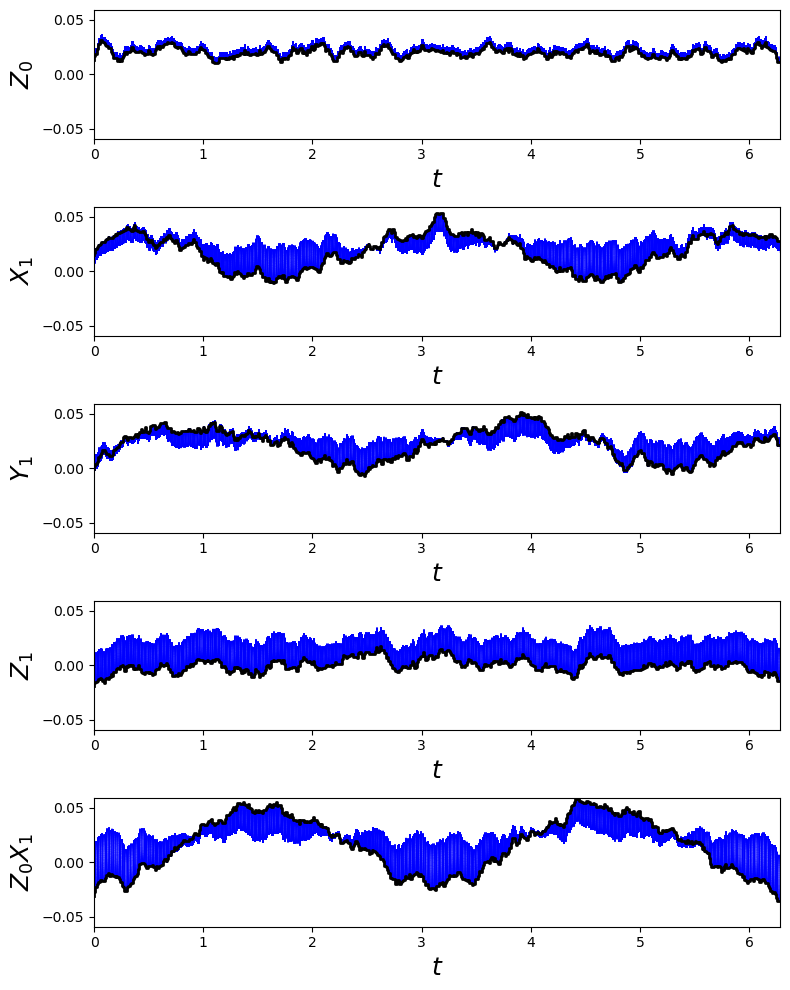

In [8]:
###Plot the resulting pulses. Black line is initialization and blue is final pulse
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);


In [9]:
### Matrix with |00> --> |00> transition amplitude normalized to 1
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j          1.48102908e-04-0.12620639j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 4.42239281e-02-0.11820456j  9.36184802e-01+0.3515082j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  -1.62428753e-01+0.07756207j  9.71845626e-01+0.19759853j]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   9.77441087e-01+0.16774391j  1.23317241e-01+0.13111763j]]

In [10]:
### Real part of the inner product and fidelity respectively
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f)) ** 2

(0.6929635862268677, 0.9603757970817899)

### Evidence for a Quantum Speed Limit
To verify that we actually have a real quantum speed limit, we repeatedly run optimizations with different final times and compare their accuracies. 

Since the convergence with $T=3\pi/2$ seems consistent, we benchmark $10$ evenly spaced final times between $\pi /2$ and $3\pi/2 $

In [11]:
Data=[]
for t_final in np.linspace(np.pi/2, 2* np.pi , 10):
    print("---------")
    times = times = np.linspace(0, t_final, 500)
    result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0,progress_bar=TextProgressBar(),phase_sensitive=False)
    Data.append(abs(_overlap(U, result.U_f)) ** 2)
    print("---------")


---------
10.0%. Run time:  92.01s. Est. time left: 00:00:13:48
20.0%. Run time: 181.02s. Est. time left: 00:00:12:04
30.0%. Run time: 274.40s. Est. time left: 00:00:10:40
40.0%. Run time: 357.14s. Est. time left: 00:00:08:55
50.0%. Run time: 436.07s. Est. time left: 00:00:07:16
60.0%. Run time: 512.39s. Est. time left: 00:00:05:41
70.0%. Run time: 581.44s. Est. time left: 00:00:04:09
80.0%. Run time: 645.55s. Est. time left: 00:00:02:41
90.0%. Run time: 709.72s. Est. time left: 00:00:01:18
Total run time: 767.94s
---------
---------
10.0%. Run time:  60.08s. Est. time left: 00:00:09:00
20.0%. Run time: 119.79s. Est. time left: 00:00:07:59
30.0%. Run time: 180.92s. Est. time left: 00:00:07:02
40.0%. Run time: 242.24s. Est. time left: 00:00:06:03
50.0%. Run time: 303.67s. Est. time left: 00:00:05:03
60.0%. Run time: 365.33s. Est. time left: 00:00:04:03
70.0%. Run time: 427.58s. Est. time left: 00:00:03:03
80.0%. Run time: 489.54s. Est. time left: 00:00:02:02
90.0%. Run time: 551.92s. Es

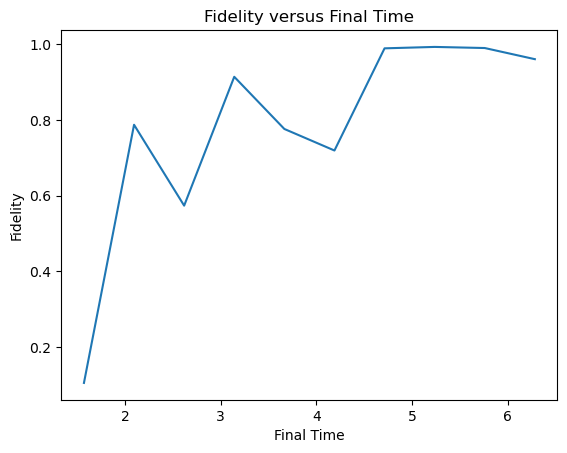

In [12]:
plt.plot(np.linspace(np.pi/2, 2* np.pi , 10), Data)
plt.title("Fidelity versus Final Time")
plt.xlabel("Final Time")
plt.ylabel("Fidelity")
plt.show()

### Quantum Speed Limits
Having a minimum required time to execute discrete operations means that gate level circuits have an inherent speed limit,suggesting that pulse-level compilations can be faster